# Greedy Regression Algorithm

In [31]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pdb import set_trace
from data.data_utils import load_dataset
import random

np.random.seed(42)

x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')


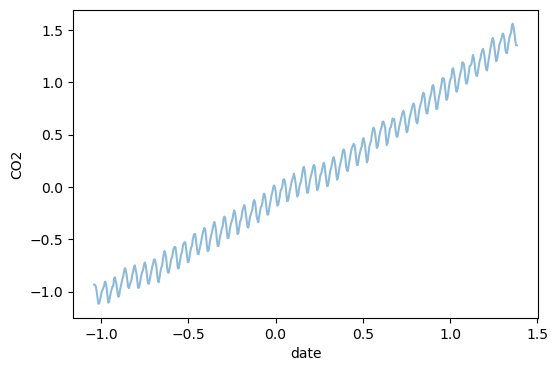

In [32]:
plt.figure(figsize=(6,4))
plt.ylabel('CO2')
plt.xlabel('date')
plt.plot(x_train.squeeze(), y_train.squeeze(), label='Exact', alpha=0.5)

plt.show()

By observation, there might be sine and cosine functions among the basis functions. There're also linear functions and even polynomials.

In [33]:
def sine(k):
    return lambda x: np.sin(np.pi * k * x)

def cosine(k):
    return lambda x: np.cos(np.pi * k * x)

def polynomial(p):
    return lambda x: x**p

In [34]:
# At least 200 basis functions
dictionary = []
k_l = np.linspace(1, 100, 100)
for k in k_l:
    dictionary += [sine(k)]
    dictionary += [cosine(k)]

for i in range(5):
    dictionary += [polynomial(i)]

print("Total basis functions: %d" %(len(dictionary)))

Total basis functions: 205


In [35]:
# LEAST SQAURE ERROR
def l2_loss(r):
    return np.sqrt(np.sum(np.square(r)))
# MINIMUM DESCRIPTION LENGTH
def find_mdl(lse, k, N):
    """
    lse: least square training error
    k: iteration number in the greedy model
    """
    return (N/2)*np.log(lse) + (k/2)*np.log(N)

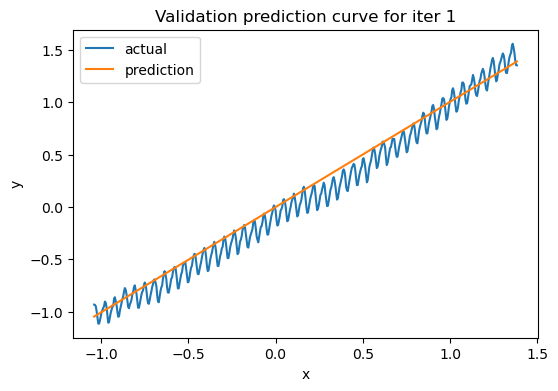

Iteration: 1, mdl: 258.998951


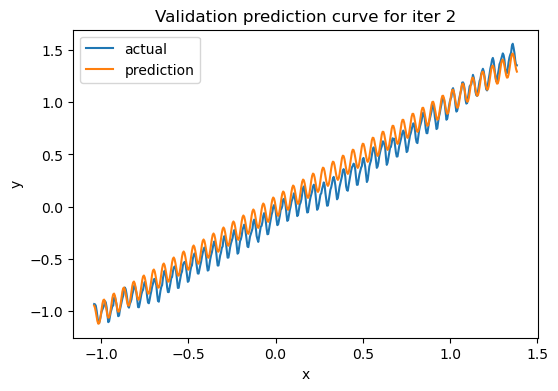

Iteration: 2, mdl: 205.080955


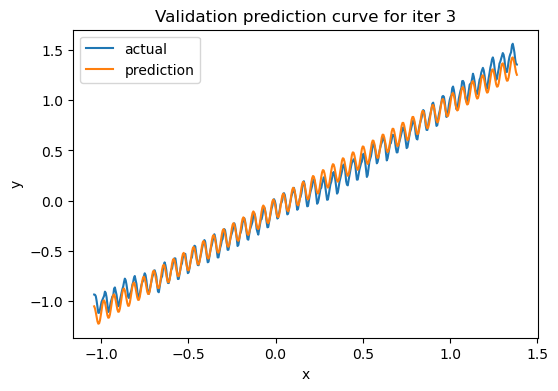

Iteration: 3, mdl: 93.829498


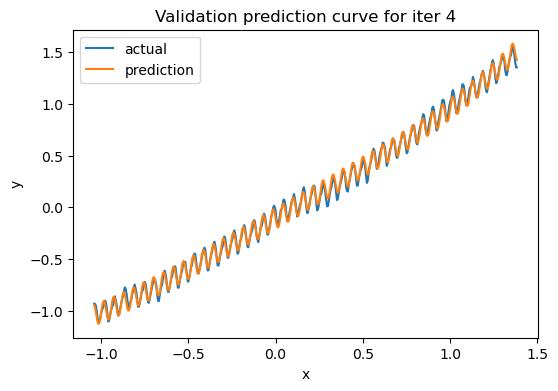

Iteration: 4, mdl: -44.022950


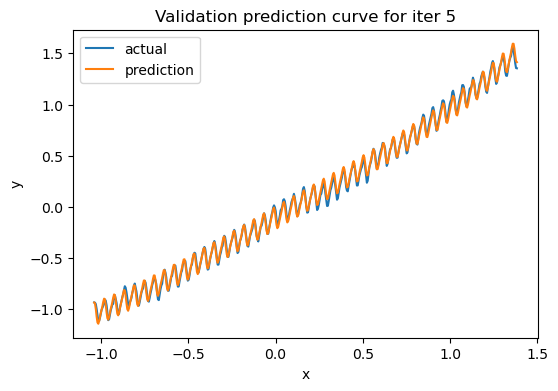

Iteration: 5, mdl: -77.556640


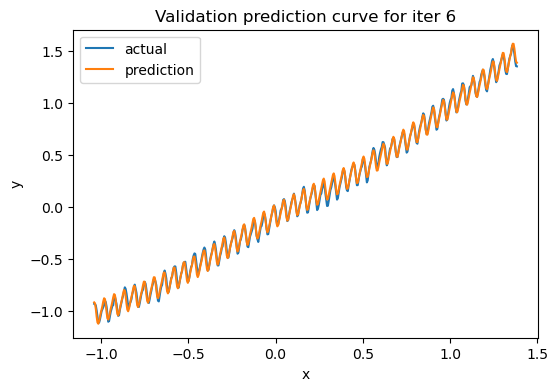

Iteration: 6, mdl: -104.798661


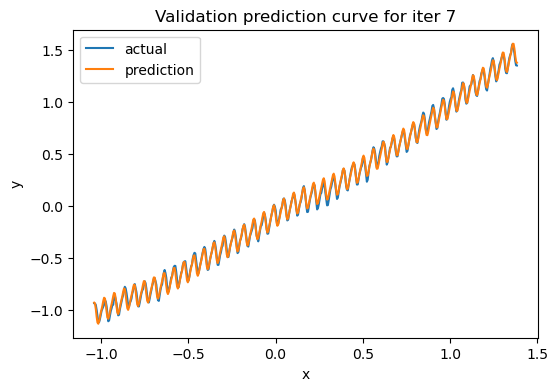

Iteration: 7, mdl: -112.462342


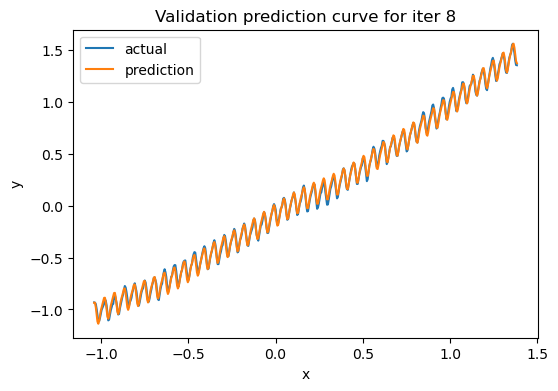

Iteration: 8, mdl: -119.079899


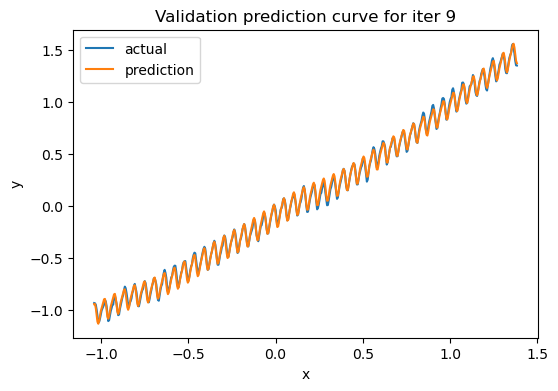

Iteration: 9, mdl: -122.884414


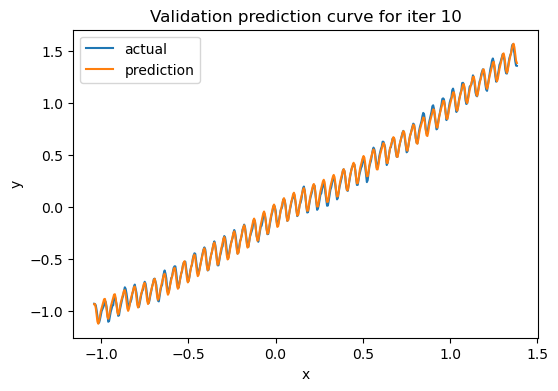

Iteration: 10, mdl: -126.585759


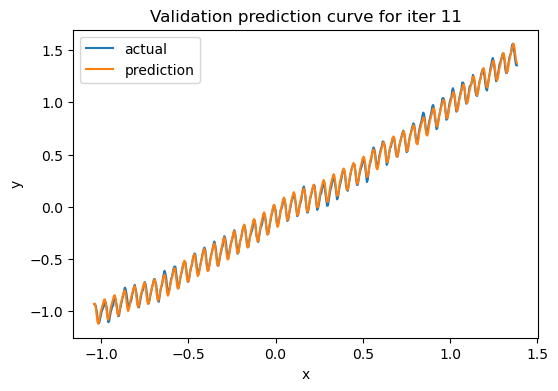

Iteration: 11, mdl: -129.751821


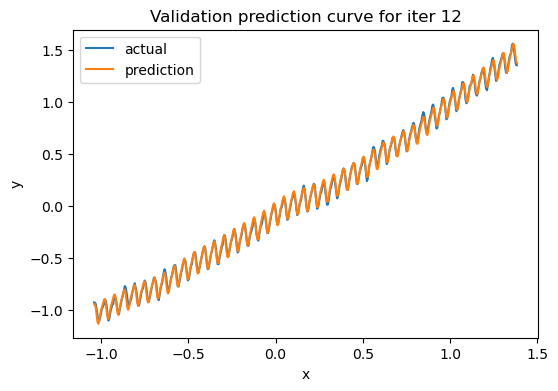

Iteration: 12, mdl: -137.854760


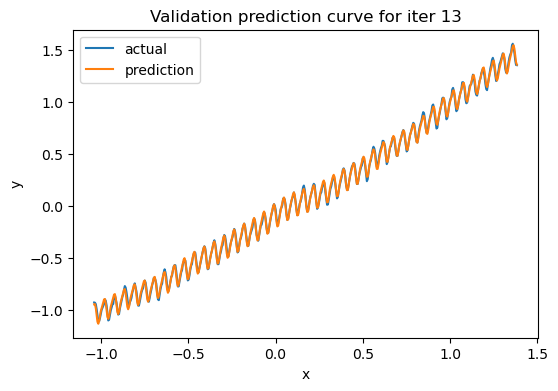

Iteration: 13, mdl: -146.476431


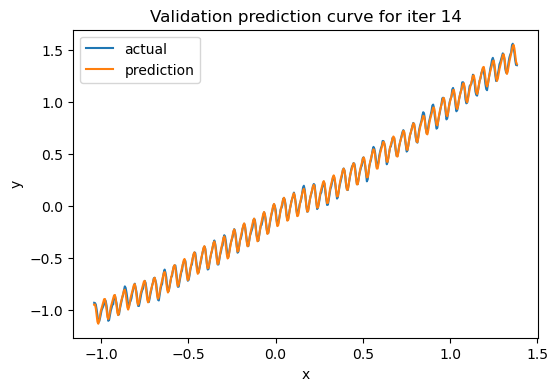

Iteration: 14, mdl: -148.424382


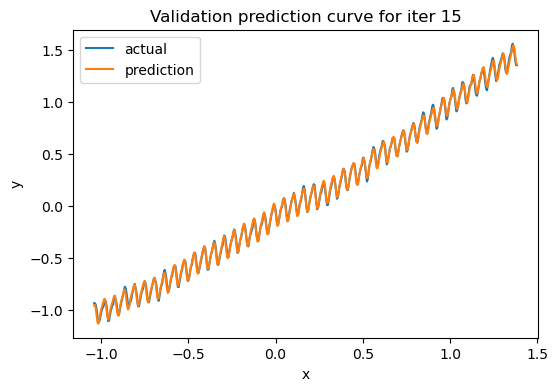

Iteration: 15, mdl: -149.562678


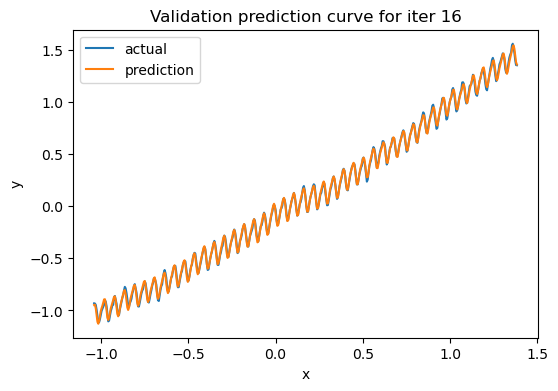

Iteration: 16, mdl: -150.774002


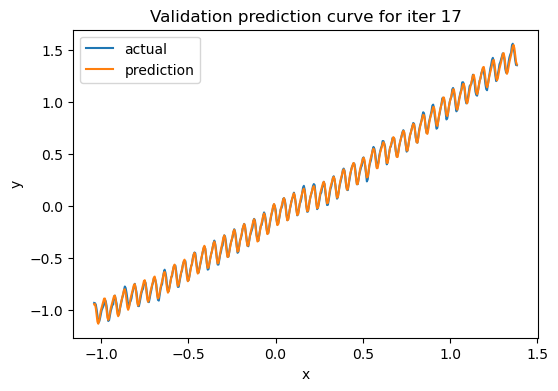

Iteration: 17, mdl: -151.320373


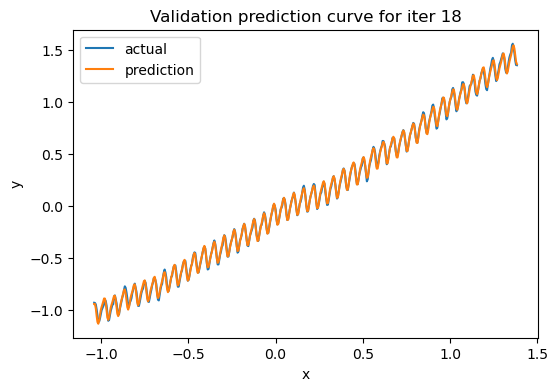

Iteration: 18, mdl: -151.549225


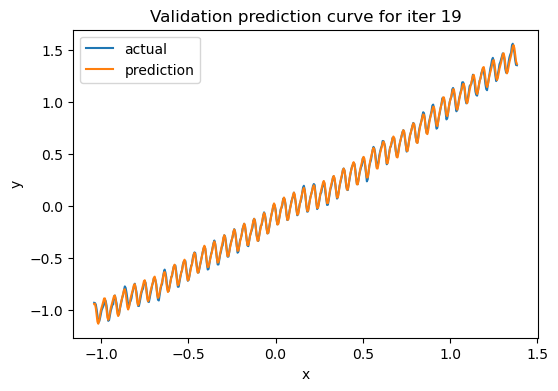

Iteration: 19, mdl: -152.525696


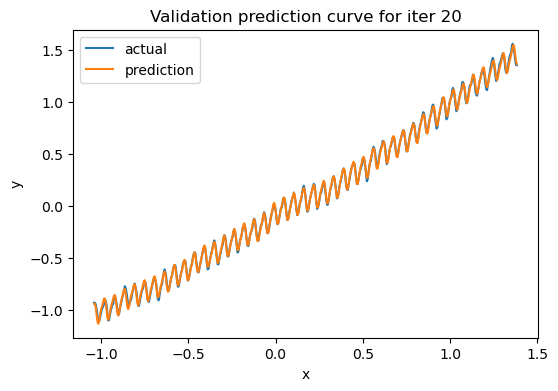

Iteration: 20, mdl: -151.656183
The optimal number of iterations is 19.


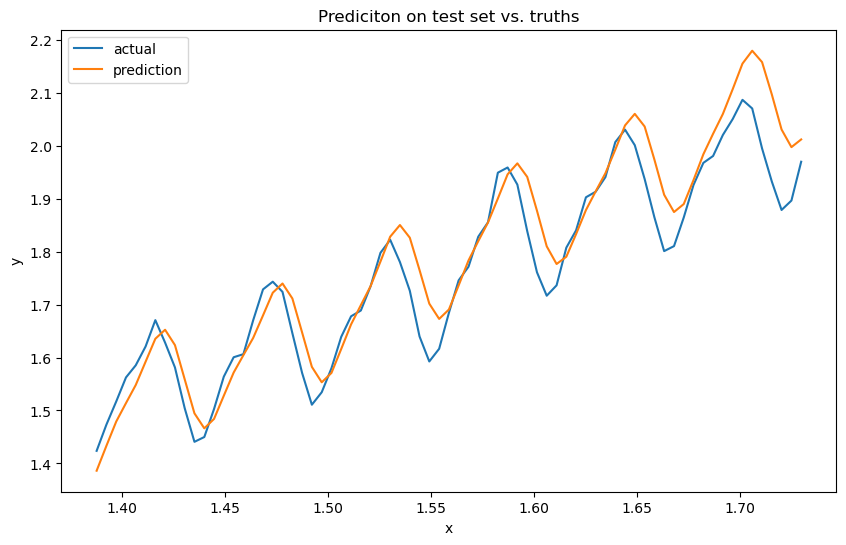

The root mean square error for testing data is 0.062144


In [36]:
def greedy_regression(y_train, x_train, x_test):
    r = y_train
    n = x_train.shape[0]
    k = 0
    I_selected = [] # indices of selected basis functions
    I_candidate = np.arange(len(dictionary)) # indices of candidate basis functions
    min_mdl = np.inf
    while I_candidate.shape[0] > 0:
        k += 1
        J = [] # metric for choosing a new basis function
        # pick a new basis function from the dictionoary that maximizes J(phi_i)
        for i in I_candidate:
            phi_i = np.array(dictionary[i](x_train))
            J += [np.square(np.matmul(phi_i.T, r)) / np.abs(np.matmul(phi_i.T, phi_i))]
        i_k  = np.argmax(J)
        # print(i_k)
        I_selected += [I_candidate[i_k]]
        # print(I_selected)
        I_candidate = np.delete(I_candidate, i_k)
        Phi_k = np.empty((n,k)) # phi vector with k colomns
        for i, idx in enumerate(I_selected):
            Phi_k[:,i] = dictionary[idx](x_train.T)
        # solve phi * w = y for the weights
        U,S,Vt = np.linalg.svd(Phi_k, full_matrices=False, compute_uv=True)
        weights = Vt.T.dot(U.T.dot(y_train) / np.reshape(S, (-1,1)))
        y_pred = Phi_k.dot(weights)
        # print(y_pred)
        # visualize
        plt.figure(figsize=(6,4))
        plt.plot(x_train, y_train, label='actual')
        plt.plot(x_train, y_pred, label='prediction')
        plt.title(f'Validation prediction curve for iter {k}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(loc='best')
        plt.show()

        # update residual r = y - phi * w
        r = y_train - y_pred
        mdl = find_mdl(lse=l2_loss(r), k=k, N=n)
        print("Iteration: %d, mdl: %f" %(k, mdl))

        if mdl < min_mdl:
            min_mdl = mdl
        else:
            break # loss starts to rise
    # get rid ofthe last one added
    print("The optimal number of iterations is %d." %(k-1))
    I_selected = I_selected[:-1]
    weights   = weights[:-1]
    Phi_test  = np.empty((x_test.shape[0], len(I_selected)))
    for i, idx in enumerate(I_selected):
        Phi_test[:,i] = dictionary[idx](x_test.T)
    y_hat = Phi_test.dot(weights)

    plt.figure(figsize=(10,6))
    plt.plot(x_test, y_test, label='actual')
    plt.plot(x_test, y_hat, label='prediction')
    plt.title('Prediciton on test set vs. truths')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='best')
    plt.show()

    rmse = np.sqrt(np.mean(np.square(y_test-y_hat)))
    print("The root mean square error for testing data is %f" %(rmse))

greedy_regression(y_train, x_train, x_test)

# final sparse model